# **Diplomado IA: Inteligencia Artificial I - Parte 2**. <br> Práctico 2: Funciones de Pérdida, Regularización y Tareas Auxiliares
---
---

**Profesores:**
- Carlos Aspillaga
- Gabriel Sepúlveda

**Ayudante:**
- Por definir
---
---

# **Instrucciones Generales**

El siguiente práctico se debe realizar **individualmente**. El formato de entrega es el **archivo .ipynb con todas las celdas ejecutadas**. Todas las preguntas deben ser respondidas en las celdas dispuestas para ello. No se aceptará el _output_ de una celda de código como respuesta.

**Nombre Alumno/a:** COMPLETAR

El siguiente práctico cuenta con 3 experimentos donde cada uno contendrá actividades a realizar.

**IMPORTANTE: habrá un bonus de 1 décima para todos aquellos alumnos/as que muestren buen orden en sus respuestas (esto aplica a legibilidad de código, buena redacción, formalidad, organización del jupyter notebook, seguimiento de instrucciones, etc). El criterio lo pondrá cada ayudante corrector. La nota máxima obtenible en el laboratorio es 7.0**

# **Índice**

>[Diplomado IA: Inteligencia Artificial I - Parte 2.  Práctico 2: Funciones de Pérdida, Regularización y Tareas Auxiliares](#scrollTo=tHopPtVaNF1K)

>[Instrucciones Generales](#scrollTo=D4--58EgLXxI)

>[Índice](#scrollTo=jCb8075QLdVx)

>[Experimento 1: Funciones de Pérdida](#scrollTo=QowbUszVAyrv)

>>[Entrenamiento de un clasificador con función de pérdida Cross-Entropy](#scrollTo=QUjcMm1-1Q68)

>>[Entrenamiento de un clasificador con función de pérdida MSE](#scrollTo=Fqc4VRj62wp4)

>>[Actividades](#scrollTo=QiOarh-8d81k)

>[Experimento 2: Regularización](#scrollTo=XmRz5CaMDuNJ)

>>[Entrenamiento de un modelo sin regularización](#scrollTo=ePn_NE89yWY9)

>>[¿Qué pasa si agregamos regularización L2?](#scrollTo=e91eKoCmWEWG)

>>[Actividades](#scrollTo=rKftFZ2W4XKJ)

>[Experimento 3: Tareas Auxiliares](#scrollTo=TbW0lMID4Bbp)

>>[Actividades](#scrollTo=iTLvN31ZyFSU)



# **Experimento 1: Funciones de Pérdida**

## Entrenamiento de un clasificador con función de pérdida Cross-Entropy

En el siguiente experimento vamos a utilizar el dataset _CIFAR-10_, que contiene imágenes de 10 clases (Avión, Auto, Pájaro, Gato, Ciervo, Perro Rana, Caballo, Barco y Camión). El objetivo será entrenar un clasificador capaz de identificar la clase solamente observando imagen.

Primero crearemos nuestro Dataloader, que se encarga de manejar los datos de entrada al modelo

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download Datasets provided by pytorch
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True,
    download=True, transform=transform
)
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False,
    download=True, transform=transform
)

# Create Dataloaders
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128,
    shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128,
    shuffle=False, num_workers=2
)

# List class names, for analysis purposes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create a dictionary of DataLoaders for train y test
loaders = {'train': trainloader, 'test': testloader}


100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Ahora visualizaremos algunas imágenes de muestra

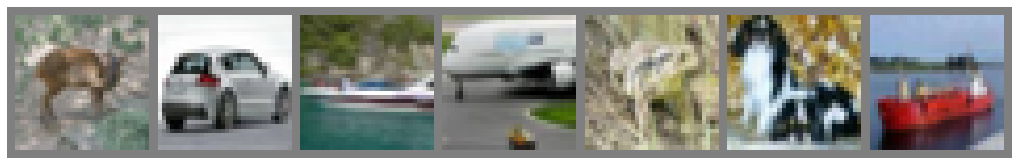

       deer             car              ship             plane            frog             dog              ship


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pylab

%matplotlib inline
pylab.rcParams['figure.figsize']=18,10

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# get 7 random training images
num_images = 7
images, labels = iter(trainloader).next()
images = images[:num_images,:,:,:]
labels = labels[:num_images]

# show images and labels
imshow(torchvision.utils.make_grid(images))
print(' '*7+''.join(str(classes[labels[i]]).ljust(17) for i in range(num_images)).strip())

A continuación creamos nuestro modelo para clasificar imágenes. 

En este caso, nuestro modelo tendrá 2 capas convolucionales y 3 capas densas

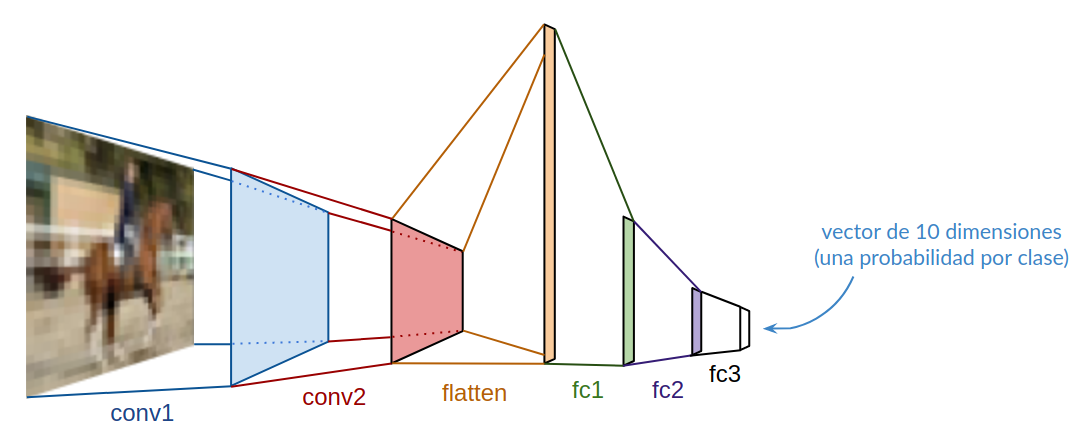

In [3]:
!if [ ! -f modelo1.png ]; then wget -q https://www.dropbox.com/s/6z6nedx6sjkz757/modelo1.png; fi
import IPython 
from IPython.display import display
import pylab
pylab.rcParams['figure.figsize']=10,10
pil_img = IPython.display.Image(filename='modelo1.png')
display(pil_img)

In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, output_dim=10):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, output_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Aquí crearemos una función para mostrar la matriz de confusión

In [4]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import itertools
import numpy as np

def print_conf_matrix(predictions, targets, classes, normalize=False, cmap=plt.cm.Blues):
    stacked = torch.stack((targets, predictions), dim=1)
    cm = torch.zeros(len(classes), len(classes), dtype=torch.int64)
    for p in stacked:
      tl, pl = p.tolist()
      cm[tl, pl] += 1
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized confusion matrix"
    else:
        title = 'Confusion matrix, without normalization'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Aqui se implementa el loop de entrenamiento y evaluacion en el set de validación

In [15]:
def train_test_model(model, loader, loss_function, n_epochs, classes):
    # Create the loss function object
    if loss_function == 'MSE':
        loss_fn = nn.MSELoss()
    else:
        loss_fn = nn.CrossEntropyLoss()

    # Create the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # This is our training loop
    for epoch in range(1, n_epochs + 1):
        print("Epoch N° {}".format(epoch))

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            cum_loss = 0.0
            cum_acc = 0.0
            cum_cnt = 0
            phase_preds = []
            phase_targets = []
            for n_batch, (sample, target) in enumerate(loaders[phase]):

                if loss_function == 'MSE':
                    # Format change so that target is consistent with the prediction format
                    target = target.float().unsqueeze(1)

                if phase == 'train':
                    # During training, we reset gradients at every batch iteration
                    optimizer.zero_grad()

                # Run model (forward pass)
                result = model(sample)

                # Compute loss
                loss = loss_fn(result, target)

                cum_loss += loss.item()
                if loss_function == 'MSE':
                    # Round predictions to the nearest integer in [0,9]
                    preds = torch.clamp(torch.round(result), 0, 9)
                else:
                    # Prediction in the greatest value in a one-hot encoding vector
                    _, preds = torch.max(result, 1)

                if phase == 'train':
                    # During training, we also do a backward pass and do a gradient step
                    loss.backward()
                    optimizer.step()
                else:
                    # Store the values needed to compute the confusion matrix
                    phase_preds.append(preds)
                    phase_targets.append(target)

                cum_acc += torch.sum((preds == target).float())
                cum_cnt += target.size(0)
                print("\r{}-Batch {}/{} Loss: {:.4f} Acc: {:.2f}%".format(
                    phase.upper(),
                    n_batch+1,
                    len(loaders[phase]),
                    cum_loss/cum_cnt,
                    100*cum_acc/cum_cnt), end="")
            if phase == 'test':
                # print the confusion matrix for the entire epoch
                phase_preds = torch.cat(phase_preds, dim=0)
                phase_targets = torch.cat(phase_targets, dim=0)
                print_conf_matrix(phase_preds, phase_targets, classes)

            print("")


Ahora entrenaremos nuestro modelo usando Cross-Entropy.

Recordemos la fórmula de la Cross-Entropy: 

$$-\sum_{x_i,y_i \in T}{y_i * \log{q(x_i)}} = -\sum_{x_i,y_i \in T}{y_i * \log{\hat{y}_i}}$$

Suponiendo que el modelo retorna un vector $[q_1$ .. $q_{10}]^T$, para un ejemplo de clase 3 nos quedará un término de este estilo (existira uno así para cada ejemplo de entrenamiento):

$$ \begin{pmatrix} 0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \end{pmatrix}^T \begin{pmatrix} \log{q_1} \\ \log{q_2} \\ \log{q_3} \\ \log{q_4} \\ \log{q_5} \\ \log{q_6} \\ \log{q_7} \\ \log{q_8} \\ \log{q_9} \\ \log{q_{10}} \end{pmatrix} = \log{q_3}$$

Con esto vemos que el único valor que nos importa maximizar es $q_3$, lo cual es ideal porque dejamos libre la distribución de los errores. Todos los otros $q_j$ solo nos importan de manera agregada (pues $\sum_j{q_j} = 1$).

Epoch N° 1
TRAIN-Batch 391/391 Loss: 0.0160 Acc: 23.33%
TEST-Batch 79/79 Loss: 0.0139 Acc: 35.07%

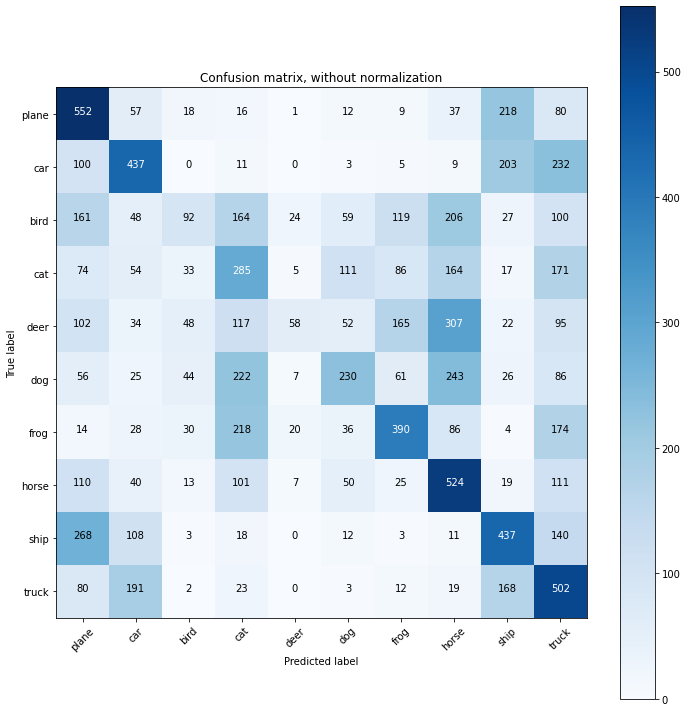


Epoch N° 2
TRAIN-Batch 391/391 Loss: 0.0124 Acc: 41.90%
TEST-Batch 79/79 Loss: 0.0116 Acc: 46.29%

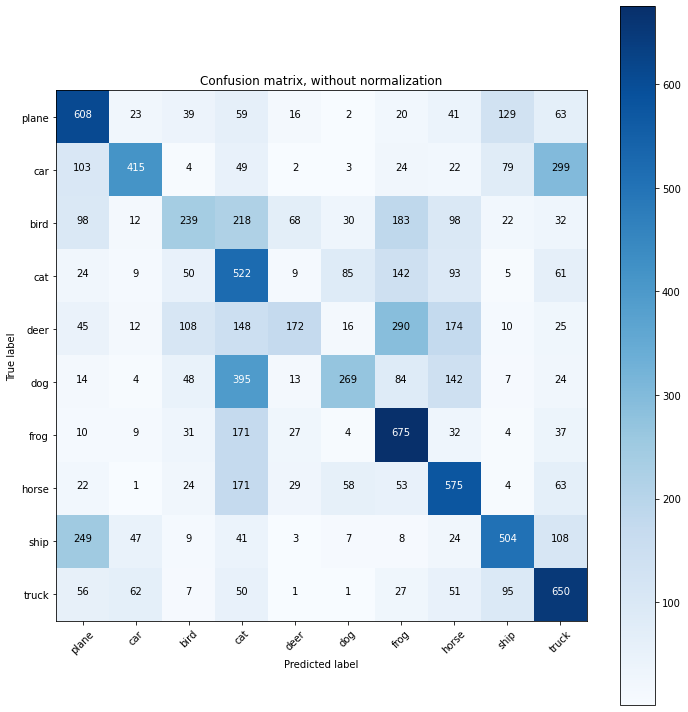

In [10]:
%matplotlib inline
pylab.rcParams['figure.figsize']=10,10

# Código para asegurar que el random parta del mismo punto al momento de ejecutar el modelo
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# Instanciar el modelo
model = Net(output_dim=len(classes))

# Ejecutar función para entrenar el modelo y testear.                  
train_test_model(model, loaders, 'Cross-Entropy', 2, classes)


## Entrenamiento de un clasificador con función de pérdida MSE

Ahora estudiemos la MSE. Veremos por qué razón no es buena idea utilizarla en un problema de clasificacion.

Usaremos el mismo modelo anterior, con la única diferencis de que esta vez usaremos una salida de 1 dimensión, que usaremos para identificar la clase (valor de 0 a 9)

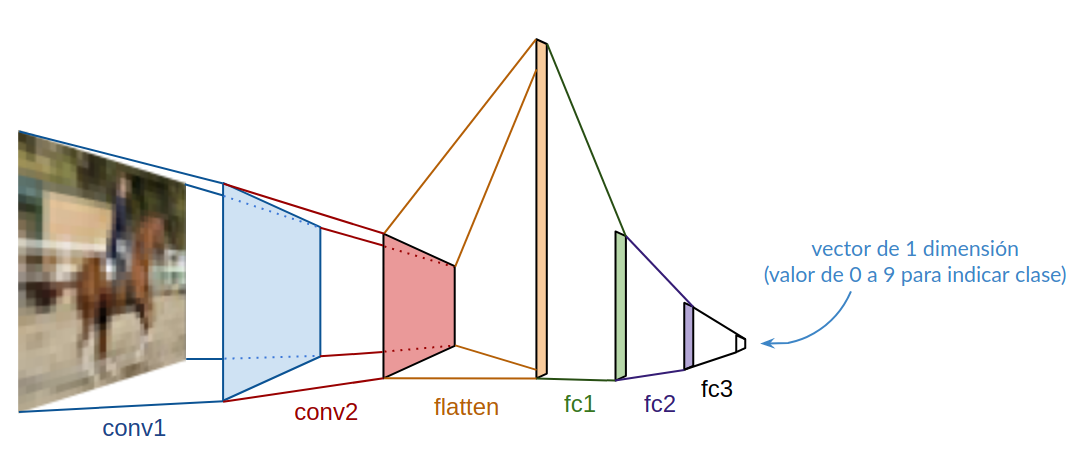

In [8]:
!if [ ! -f modelo2.png ]; then wget -q https://www.dropbox.com/s/680xmwsfdzg71nh/modelo2.png; fi
import IPython 
pil_img = IPython.display.Image(filename='modelo2.png')
display(pil_img)

Recordemos la fórmula de la MSE asumiendo que el modelo retorna una predicción como un único valor entre 0 y 9 para indicar la clase: 

$$\frac{1}{N} \sum_{x_i,y_i \in T}^N{(\hat{y}_{i} - y_{i})^2}$$

Es fácil ver que si el modelo predijera siempre clase 9, entonces tendría el siguiente MSE (asumiendo clases balanceadas):

$$\frac{(9-0)^2 + (9-1)^2 + (9-2)^2 + (9-3)^2 + (9-4)^2 + (9-5)^2 + (9-6)^2 + (9-7)^2 + (9-8)^2 +(9-9)^2}{10} = $$

In [7]:
(9**2 + 8**2 + 7**2 + 6**2 + 5**2 + 4**2 + 3**2 + 2**2 +1**2 + 0**2)/10

28.5

En cambio, si el modelo predijera siempre clase 5, tendría el siguiente MSE (asumiendo clases balanceadas):

$$\frac{(5-0)^2 + (5-1)^2 + (5-2)^2 + (5-3)^2 + (5-4)^2 + (5-5)^2 + (5-6)^2 + (5-7)^2 + (5-8)^2 +(5-9)^2}{10} = $$

In [8]:
(5**2 + 4**2 + 3**2 + 2**2 + 1**2 + 0**2 + (-1)**2 + (-2)**2 + (-3)**2 + (-4)**2)/10 

8.5

Con esto vemos que el modelo no es indiferente al valor numérico que le asigna a las predicciones, pues errores grandes se penalizan más que errores pequeños.

Ahora repetiremos el mismo entrenamiento que hicimos con Cross-Entropy, pero esta vez usando pérdida MSE

Epoch N° 1
TRAIN-Batch 391/391 Loss: 0.0625 Acc: 10.68%
TEST-Batch 79/79 Loss: 0.0585 Acc: 10.33%

C:\Users\Arie\AppData\Local\Temp/ipykernel_14268/1062933937.py:11: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cm[tl, pl] += 1


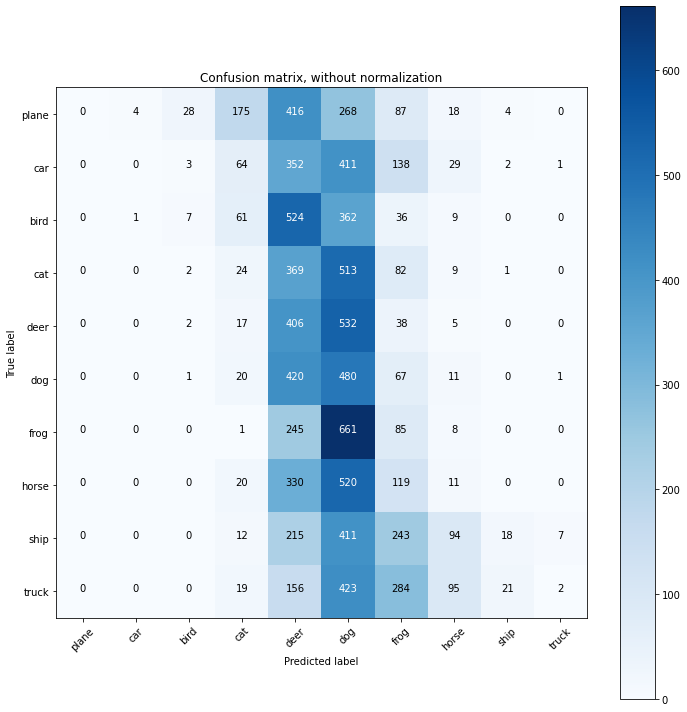


Epoch N° 2
TRAIN-Batch 391/391 Loss: 0.0557 Acc: 12.24%
TEST-Batch 79/79 Loss: 0.0541 Acc: 14.41%

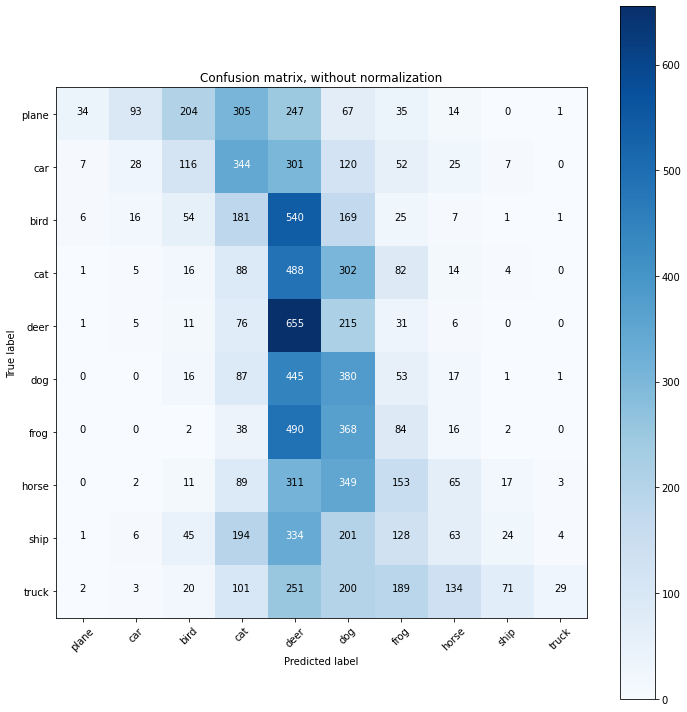


Epoch N° 3
TRAIN-Batch 391/391 Loss: 0.0525 Acc: 13.22%
TEST-Batch 79/79 Loss: 0.0529 Acc: 15.82%

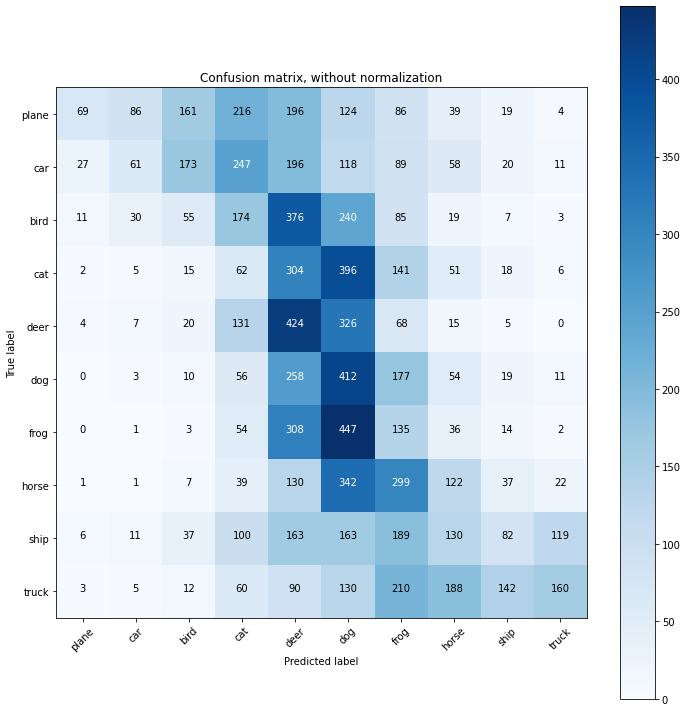


Epoch N° 4
TRAIN-Batch 391/391 Loss: 0.0482 Acc: 14.47%
TEST-Batch 79/79 Loss: 0.0522 Acc: 12.25%

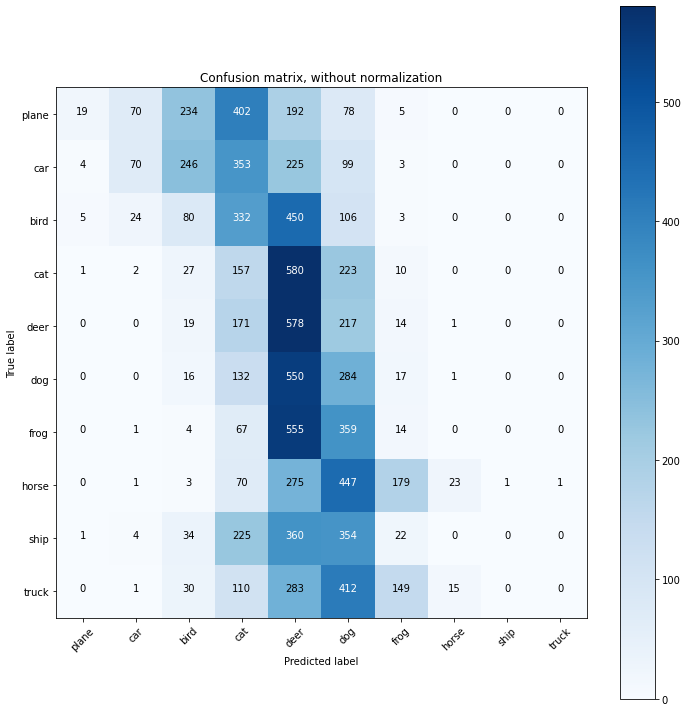


Epoch N° 5
TRAIN-Batch 391/391 Loss: 0.0456 Acc: 15.38%
TEST-Batch 79/79 Loss: 0.0455 Acc: 15.81%

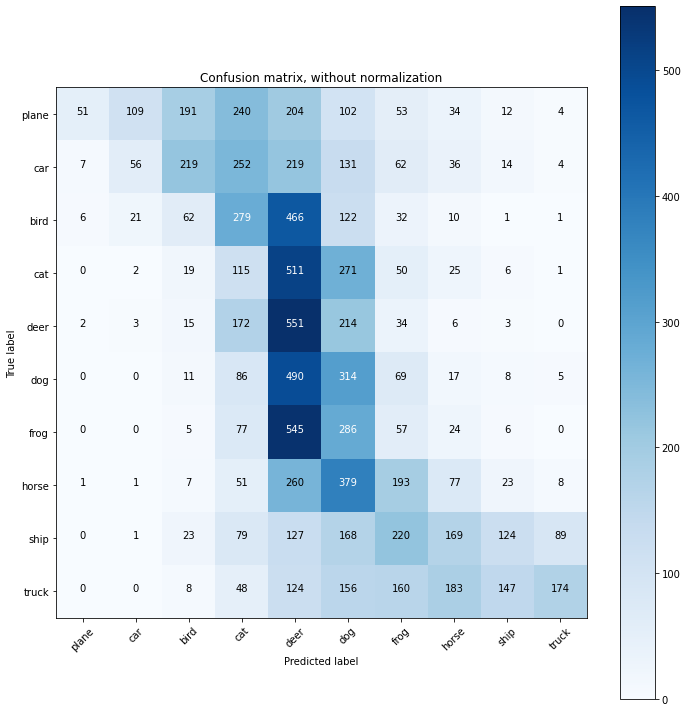


Epoch N° 6
TRAIN-Batch 391/391 Loss: 0.0436 Acc: 16.31%
TEST-Batch 79/79 Loss: 0.0455 Acc: 18.73%

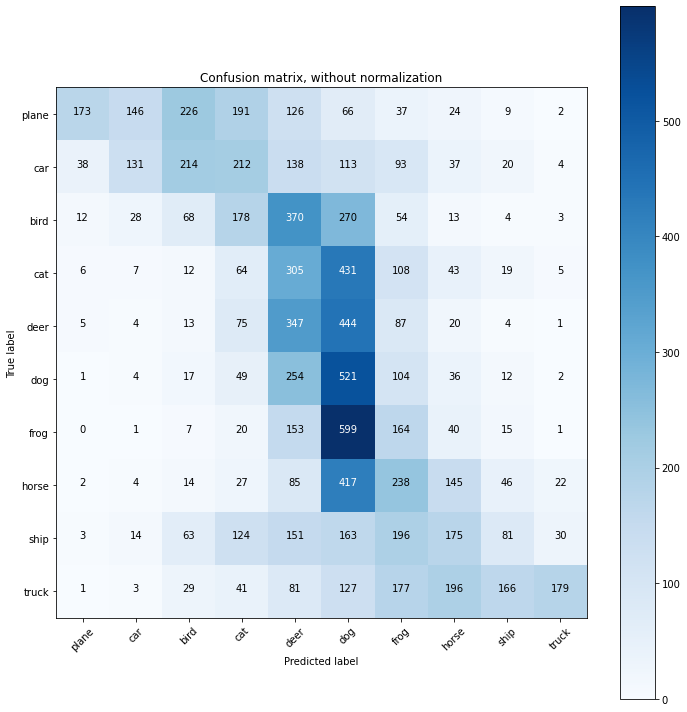


Epoch N° 7
TRAIN-Batch 391/391 Loss: 0.0415 Acc: 17.14%
TEST-Batch 79/79 Loss: 0.0436 Acc: 15.72%

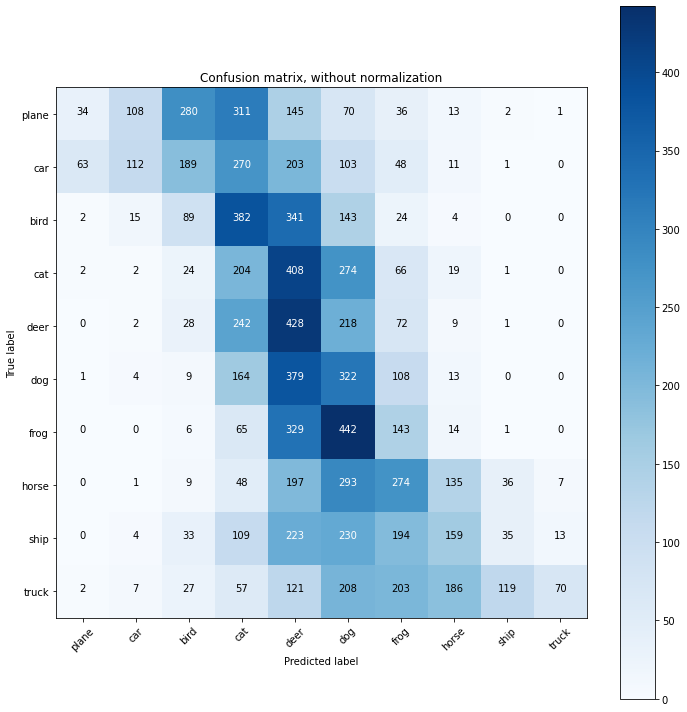


Epoch N° 8
TRAIN-Batch 391/391 Loss: 0.0400 Acc: 17.89%
TEST-Batch 79/79 Loss: 0.0448 Acc: 14.67%

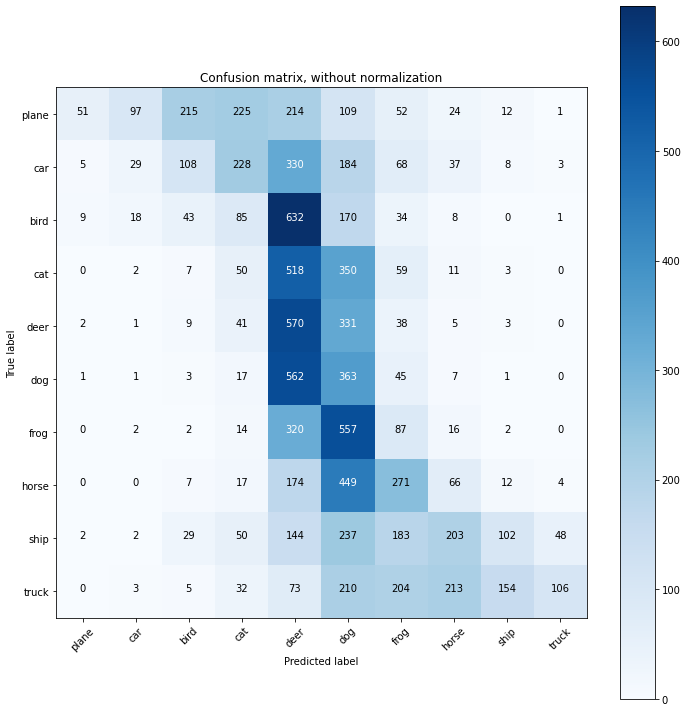


Epoch N° 9
TRAIN-Batch 391/391 Loss: 0.0388 Acc: 18.44%
TEST-Batch 79/79 Loss: 0.0425 Acc: 20.01%

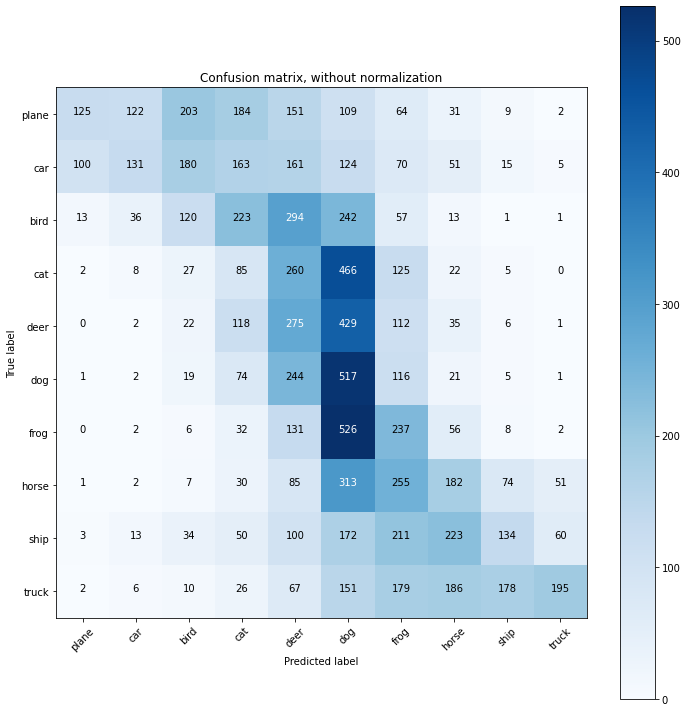


Epoch N° 10
TRAIN-Batch 391/391 Loss: 0.0377 Acc: 18.91%
TEST-Batch 79/79 Loss: 0.0429 Acc: 17.51%

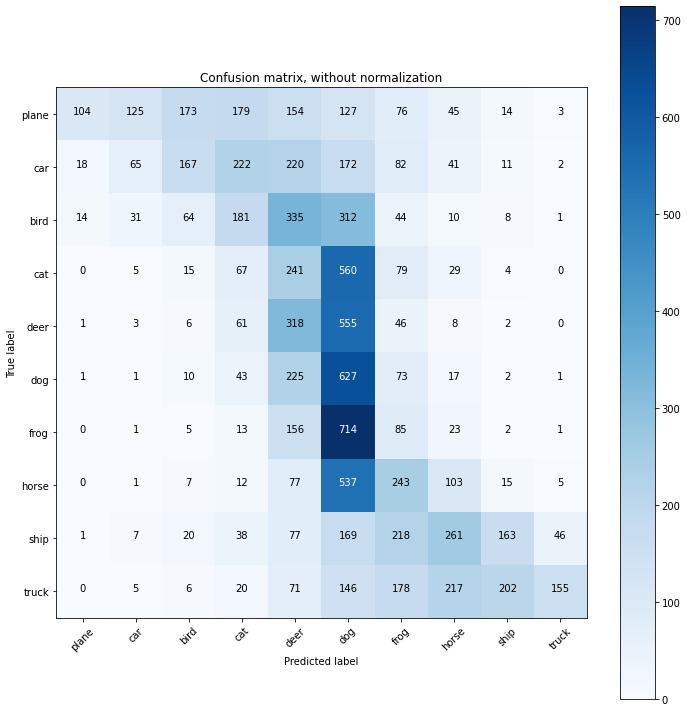

In [19]:
# Código para asegurar que el random parta del mismo punto al momento de ejecutar el modelo
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

# Instanciar el modelo
model = Net(output_dim=1)

# Ejecutar función para entrenar el modelo y testear.                  
train_test_model(model, loaders, 'MSE', 10, classes)


## Actividades

**¿En cuáles de estos problemas usaría MSE en lugar de Cross-Entropy?
Marque el check-box de todas las alternativas que correspondan**

*   **1) Un sistema que a partir del historial de compras de un cliente, estima la probabilidad de que vaya o no a comprar pasajes en avión dentro de los próximos 30 días**

In [ ]:
#@title Respuesta 1
Respuesta = True #@param {type:"boolean"}

*   **2) Un sistema que permite decidir qué tan positivo o negativo es un comentario en un foro mediante la predicción de un score continuo entre -1 y 1**



In [ ]:
#@title Respuesta 2
Respuesta = True #@param {type:"boolean"}

*   **3) Un sistema que a estima el precio del Dólar a partir del ánalisis de los mensajes de twitter relacionados con Donald Trump**

In [ ]:
#@title Respuesta 3
Respuesta = True #@param {type:"boolean"}

*   **4) Un sistema que a debe aproximar una función discreta que mide la cantidad de alumnos que asistirán a la próxima clase (un número entero entre 1 y 40), a partir del título de la clase y el nombre del profesor**

In [ ]:
#@title Respuesta 4
Respuesta = False #@param {type:"boolean"}

*   **5) Un sistema que a partir de una imagen en blanco y negro predice para cada pixel el color que debería tener si la imagen fuera a color. Para cada pixel predice 3 valores entre 0 y 255: R: Cantidad de Rojo, G: Cantidad de Verde, B: Cantidad de Azul.**

In [ ]:
#@title Respuesta 5
Respuesta = False #@param {type:"boolean"}

*   **6) Un sistema que a debe aproximar una función continua altamente no lineal**


In [ ]:
#@title Respuesta 6
Respuesta = True #@param {type:"boolean"}

# **Experimento 2: Regularización**

## Entrenamiento de un modelo sin regularización

A continuación analizaremos el efecto de aplicar regularización a la función de pérdida al entrenar una red neuronal para una tarea de clasificación.


El código que aparece a continuación permite la descarga de un archivo que contiene el dataset que utilizaremos en la presente sección.
Este archivo contiene un conjunto de vectores bidimensionales, los que pueden pertencer a una de las dos clases definidas: 0 o 1. El archivo consta de 4 columnas separadas por coma, las  cuales corresponden a:
 * Coordenada x del punto
 * Coordenada y del punto
 * Identificador de la clase (0 o 1)
 * Identificador de si pertenece al conjunto de entrenamiento (1) o test (0)

Luego de descargar el archivo, se imprimirán las primeras y las últimas 5 líneas del archivo para que observe su contenido.

In [20]:
!if [ ! -f sample_data.csv ]; then wget -q https://www.dropbox.com/s/amibk8qtgvtw7bk/sample_data.csv; fi
!head -5 sample_data.csv
!echo "----------------------------------------"
!tail -5 sample_data.csv

No se esperaba ! en este momento.
"head" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


"----------------------------------------"


"tail" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


El siguiente código define una función que permitirá leer los datos desde el archivo descargado, y una función para poder graficar los datos asignando colores a cada vector según su clase.
Posteriormente se hace un llamado a cada una de ellas para visualizar como se distribuyen las clases.

In [21]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pylab

%matplotlib inline
pylab.rcParams['figure.figsize']=10,8

def load_data( filename ):
  data_train = {'class_1': [], 'class_2': [], 'raw': []}
  data_test = {'class_1': [], 'class_2': [], 'raw': []}
  with open(filename, newline='') as csvfile:
    datareader = csv.reader(csvfile)
    for row in datareader:
      if row[0] == 'X1': # skip header
        continue
      if int(row[3]) == 1: # training sample
        data_train['raw'].append([float(row[0]), float(row[1]), float(row[2])])
        if float(row[2]) == 0.0:
          data_train['class_1'].append([float(row[0]), float(row[1])])
        else:
          data_train['class_2'].append([float(row[0]), float(row[1])])
      else: # test sample
        data_test['raw'].append([float(row[0]), float(row[1]), float(row[2])])
        if float(row[2]) == 0.0:
          data_test['class_1'].append([float(row[0]), float(row[1])])
        else:
          data_test['class_2'].append([float(row[0]), float(row[1])])
  data_train = { key: np.array(data_train[key]) for key in data_train }
  data_test = { key: np.array(data_test[key]) for key in data_test }
  return data_train, data_test

def plot_dataset(data, title):
  plt.plot(data['class_1'][:,0], data['class_1'][:,1], 'o', label=r'class 1')
  plt.plot(data['class_2'][:,0], data['class_2'][:,1], 'o', label=r'class 2')
  plt.title(title, fontsize=17)
  plt.ylabel('y', fontsize=14)
  plt.xlabel('x', fontsize=14)
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=25)
  plt.grid()
  plt.show()

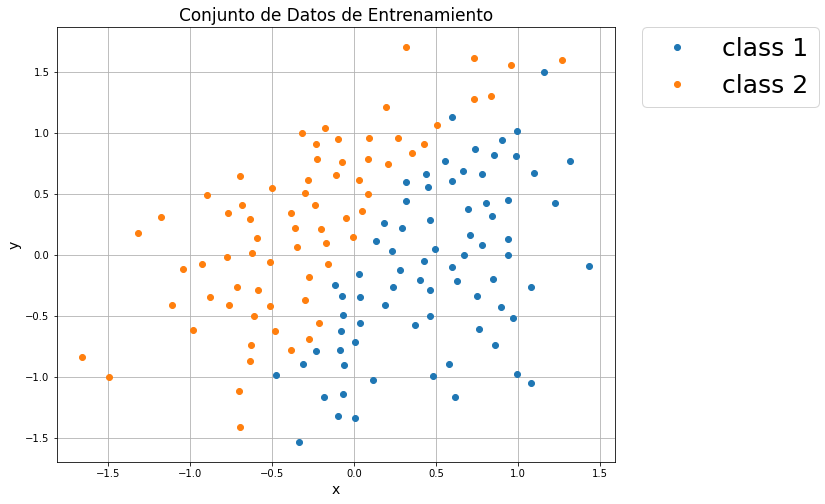

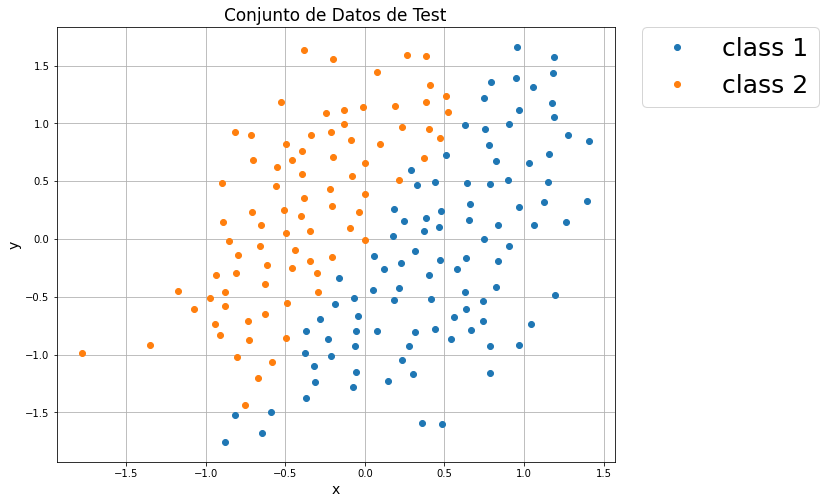

In [22]:
data_train, data_test = load_data('sample_data.csv')
plot_dataset(data_train, 'Conjunto de Datos de Entrenamiento')
plot_dataset(data_test, 'Conjunto de Datos de Test')

A continuación se definen las clases necesarias para definir un *Dataloader*, el cual es un objeto que permitirá iterar cómodamente sobre los datos dentro del loop de entrenamiento.

In [37]:
from torch.utils.data import Dataset, DataLoader

class TwoClassesDataset(Dataset):

  def __init__(self, dataset, transform = None):
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    if torch.is_tensor( idx):
      idx = idx.tolist()
    sample = {'input': self.dataset[idx, :2], 'target': self.dataset[idx, 2]}
    if self.transform:
      sample = self.transform(sample)
    return sample

# Conversor de datos generados por dataset
class ToTensor(object):
  def __call__(self, sample):
    input_, target_ = sample['input'].astype(np.float32), int(sample['target'])
    return {'input': torch.from_numpy(input_), 'target': target_ }

La siguiente clase, que llamaremos ClassificationModel, implementa una red neuronal de 3 capas utilizando el framework *PyTorch*. Esta recibe como entreda un valor de dos dimensiones (x, y) y su estructura interna ha sido definida como:

 * Layer 1: 1000 unidades
 * Layer 2: 1000 unidades
 * Layer 3 (salida): 2 unidades

In [38]:
import torch
import torch.nn as nn

class ClassificationModel( nn.Module ):

  def __init__( self ):
    super(ClassificationModel, self).__init__()
    self.actfunc_relu = nn.ReLU()
    self.layer1 = nn.Linear(2, 1000) # Capa 1: 2 entradas y 1000 salidas
    self.layer2 = nn.Linear(1000, 1000) # Capa 2: 1000 entradas y 1000 salidas
    self.layer3 = nn.Linear(1000, 1) # Capa 3: 1000 entradas y 1 salida

  def forward(self, x):
    x = self.actfunc_relu(self.layer1(x))
    x = self.actfunc_relu(self.layer2(x))
    x = self.layer3(x)
    # notar que no usamos una softmax pues usaremos una loss que la trae incorporada
    return x

La siguiente función implementa el loop de entrenamiento que se encargará de actualizar los parámetros de la red con el fin de ajustar el modelo a los datos de entrenamiento.

In [39]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

def fit(model, criterion, optimizer, dataloader, n_epochs = 100):
  scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.9, patience=10, verbose=False)
  for epoch in range(n_epochs):
    model.train()
    epoch_train_loss = 0.0
    epoch_train_accu = 0.0
    epoch_tot_elements = 0.0
    for i_batch, sample_batched in enumerate(dataloader):
      input_batch = sample_batched['input'].to(device)
      target_batch = sample_batched['target'].to(device).unsqueeze(1).float()

      prediction = model(input_batch)
      loss = criterion(prediction, target_batch)
      accuracy = model_accuracy(prediction, target_batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batch_sz = float(input_batch.size(0))
      epoch_train_loss += loss.item() * batch_sz
      epoch_train_accu += accuracy * batch_sz
      epoch_tot_elements += batch_sz

    epoch_train_loss /= epoch_tot_elements
    epoch_train_accu /= epoch_tot_elements

    # Decay Learning Rate
    scheduler.step(epoch_train_accu)

    print('Epoch %d: train loss %f acc %f' % (epoch+1, epoch_train_loss, epoch_train_accu))

def evaluate(model, criterion, dataloader):
  model.eval()
  test_loss = 0.0
  test_accu = 0.0
  tot_elements = 0
  for i_batch, sample_batched in enumerate(dataloader):
    input_batch = sample_batched['input'].to(device)
    target_batch = sample_batched['target'].to(device).unsqueeze(1).float()

    prediction = model(input_batch)
    loss = criterion(prediction, target_batch)
    accuracy = model_accuracy(prediction, target_batch)

    batch_sz = float(input_batch.size(0))
    test_loss += loss.item() * batch_sz
    test_accu += accuracy * batch_sz
    tot_elements += batch_sz

  test_loss /= tot_elements
  test_accu /= tot_elements
  print('Test loss %f acc %f' % (test_loss, test_accu))

def model_accuracy(predicted, target):
  correct = ((predicted > 0.0) == (target > 0.0)).float().sum()
  accuracy = float(correct) / float(target.shape[0])
  return accuracy

A continuación se crean los objetos encargados de:

 * Dataloader: encargado de cargar los datos e iterar sobre ellos
 * Modelo de clasificación: clase ClassificationModel
 * Función de pérdida: Cross Entropy
 * Algoritmo de optimización: Adam

Dentro del algoritmo de optimización podrá encontrar el parámetro *weight_decay*. Este permite controlar el nivel de penalización aplicado sobre la función de pérdida a través de una regularización del tipo L2.

Finalmente, se inicia el entrenamiento del modelo durante 100 épocas. Este es realizado por medio de un llamado a la función *fit* definida más arriba.

In [87]:
import torch.optim as optim
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Creación de Dataloader
two_classes_trainset = TwoClassesDataset(data_train['raw'], transform = transforms.Compose([ToTensor()]))
dataloader_train = DataLoader(two_classes_trainset, batch_size = 256, shuffle = True, num_workers = 0)
two_classes_testset = TwoClassesDataset(data_test['raw'], transform = transforms.Compose([ToTensor()]))
dataloader_test = DataLoader(two_classes_testset, batch_size = 256, shuffle = False, num_workers = 0)

# Creación de modelo
model = ClassificationModel()
model.to(device)

# Creación de instancias para la función de pérdida y optimizador
# Parámetro Weight Decay indica la importancia que asignaremos a la regularización L2 en la pérdida (en este caso, 0)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 0.0)

# Entrenamiento del modelo
fit(model, criterion, optimizer, dataloader_train, 150)

Epoch 1: train loss 0.704198 acc 0.486111
Epoch 2: train loss 0.443034 acc 0.930556
Epoch 3: train loss 0.309837 acc 0.951389
Epoch 4: train loss 0.231094 acc 0.965278
Epoch 5: train loss 0.183221 acc 0.958333
Epoch 6: train loss 0.151764 acc 0.965278
Epoch 7: train loss 0.129915 acc 0.965278
Epoch 8: train loss 0.114740 acc 0.965278
Epoch 9: train loss 0.104038 acc 0.965278
Epoch 10: train loss 0.096149 acc 0.965278
Epoch 11: train loss 0.090319 acc 0.972222
Epoch 12: train loss 0.086223 acc 0.965278
Epoch 13: train loss 0.083206 acc 0.965278
Epoch 14: train loss 0.080677 acc 0.965278
Epoch 15: train loss 0.078549 acc 0.965278
Epoch 16: train loss 0.076804 acc 0.972222
Epoch 17: train loss 0.075301 acc 0.972222
Epoch 18: train loss 0.073779 acc 0.972222
Epoch 19: train loss 0.072361 acc 0.972222
Epoch 20: train loss 0.071106 acc 0.972222
Epoch 21: train loss 0.069940 acc 0.972222
Epoch 22: train loss 0.068729 acc 0.972222
Epoch 23: train loss 0.067581 acc 0.965278
Epoch 24: train loss

A continuación revisaremos cómo le fue al modelo en el set de test

In [88]:
evaluate(model, criterion, dataloader_test)

Test loss 0.329370 acc 0.922652


La siguiente función permite crear un gráfico con el límite de clasificación aprendido por el modelo, y los datos de entrenamiento entregados durante entrenamiento.

In [89]:
import matplotlib.pyplot as plt
import pylab

%matplotlib inline
pylab.rcParams['figure.figsize']=10,8

def plot_classification_surface(model, dataset, title):
  x_range = np.linspace( -2.0, 2.0, 500 )
  y_range = np.linspace( -2.0, 2.0, 500 )
  xx, yy = np.meshgrid( x_range, y_range )
  fig, ax = plt.subplots()
  dset = np.c_[xx.ravel(), yy.ravel()]
  dset = torch.Tensor(dset).to( device)
  Z = model(dset)
  Z = (Z>0).float().reshape(xx.shape).cpu().detach().numpy()

  ax.contourf(xx, yy, Z, cmap = plt.cm.Paired)
  ax.scatter(dataset['raw'][:,0], dataset['raw'][:,1], c = dataset['raw'][:,2].astype( np.int ), cmap = plt.cm.autumn)
  plt.title(title, fontsize=17)
  plt.ylabel('y', fontsize=14)
  plt.xlabel('x', fontsize=14)
  plt.grid()
  plt.show()

C:\Users\Arie\AppData\Local\Temp/ipykernel_14268/1940641225.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.scatter(dataset['raw'][:,0], dataset['raw'][:,1], c = dataset['raw'][:,2].astype( np.int ), cmap = plt.cm.autumn)


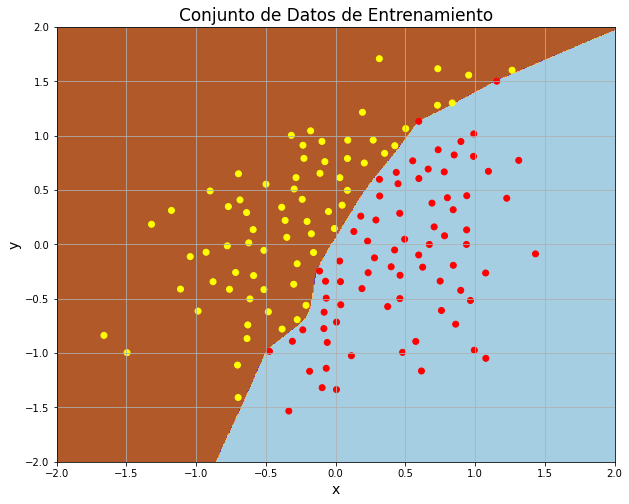

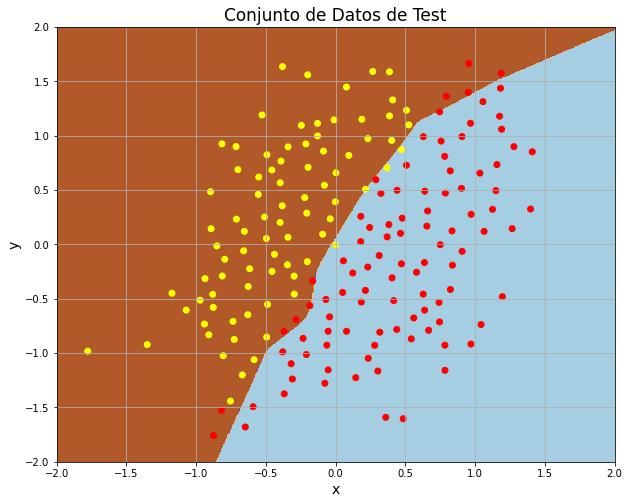

In [90]:
plot_classification_surface(model, data_train, 'Conjunto de Datos de Entrenamiento')
plot_classification_surface(model, data_test, 'Conjunto de Datos de Test')

## ¿Qué pasa si agregamos regularización L2?

In [97]:
import torch.optim as optim
from torchvision import transforms

device = torch.device( 'cuda' if torch.cuda.is_available() else 'cpu' )

# Creación de Dataloader
two_classes_trainset = TwoClassesDataset(data_train['raw'], transform = transforms.Compose([ToTensor()]))
dataloader_train = DataLoader(two_classes_trainset, batch_size = 256, shuffle = True, num_workers = 0)
two_classes_testset = TwoClassesDataset(data_test['raw'], transform = transforms.Compose([ToTensor()]))
dataloader_test = DataLoader(two_classes_testset, batch_size = 256, shuffle = False, num_workers = 0)

# Creación de modelo
model = ClassificationModel()
model.to( device )

# Creación de instancias para la función de pérdida y optimizador
# Parámetro Weight Decay indica la importancia que asignaremos a la regularización L2 en la pérdida(en este caso, 0.2)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 0.2)

# Entrenamiento del modelo
fit(model, criterion, optimizer, dataloader_train, 150)

Epoch 1: train loss 0.705093 acc 0.381944
Epoch 2: train loss 0.608805 acc 0.951389
Epoch 3: train loss 0.540790 acc 0.951389
Epoch 4: train loss 0.489572 acc 0.951389
Epoch 5: train loss 0.449587 acc 0.944444
Epoch 6: train loss 0.417789 acc 0.944444
Epoch 7: train loss 0.392241 acc 0.951389
Epoch 8: train loss 0.371189 acc 0.951389
Epoch 9: train loss 0.353481 acc 0.951389
Epoch 10: train loss 0.338631 acc 0.951389
Epoch 11: train loss 0.326060 acc 0.944444
Epoch 12: train loss 0.315208 acc 0.944444
Epoch 13: train loss 0.305678 acc 0.951389
Epoch 14: train loss 0.297087 acc 0.951389
Epoch 15: train loss 0.289974 acc 0.951389
Epoch 16: train loss 0.283319 acc 0.951389
Epoch 17: train loss 0.277009 acc 0.951389
Epoch 18: train loss 0.271022 acc 0.951389
Epoch 19: train loss 0.265341 acc 0.951389
Epoch 20: train loss 0.259938 acc 0.958333
Epoch 21: train loss 0.254819 acc 0.958333
Epoch 22: train loss 0.249968 acc 0.958333
Epoch 23: train loss 0.245369 acc 0.958333
Epoch 24: train loss

In [92]:
evaluate(model, criterion, dataloader_test)

Test loss 0.212659 acc 0.955801


C:\Users\Arie\AppData\Local\Temp/ipykernel_14268/1940641225.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.scatter(dataset['raw'][:,0], dataset['raw'][:,1], c = dataset['raw'][:,2].astype( np.int ), cmap = plt.cm.autumn)


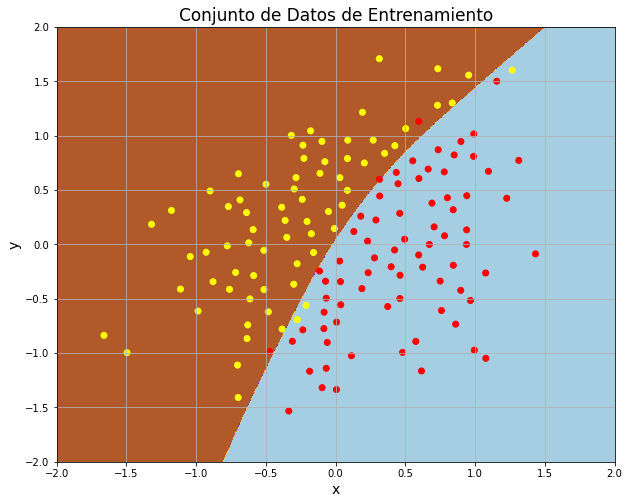

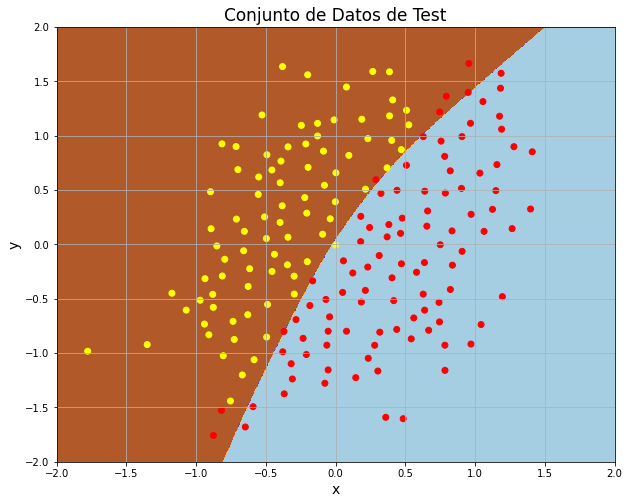

In [93]:
plot_classification_surface(model, data_train, 'Conjunto de Datos de Entrenamiento')
plot_classification_surface(model, data_test, 'Conjunto de Datos de Test')

C:\Users\Arie\AppData\Local\Temp/ipykernel_14268/1940641225.py:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ax.scatter(dataset['raw'][:,0], dataset['raw'][:,1], c = dataset['raw'][:,2].astype( np.int ), cmap = plt.cm.autumn)


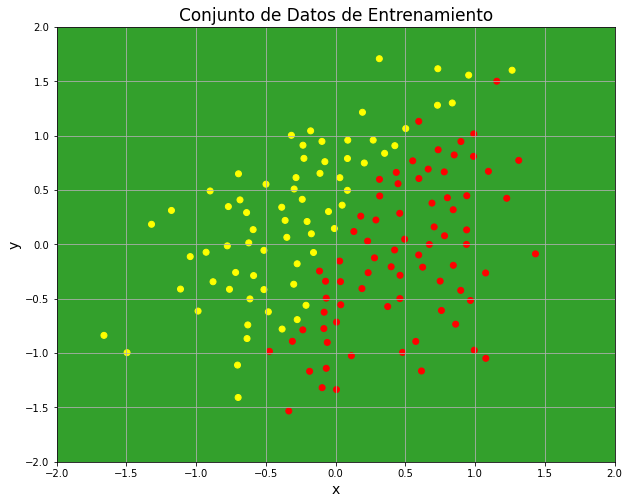

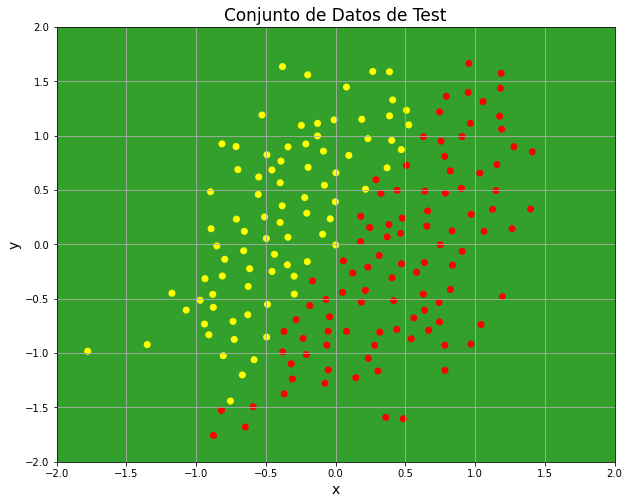

In [96]:
plot_classification_surface(model, data_train, 'Conjunto de Datos de Entrenamiento')
plot_classification_surface(model, data_test, 'Conjunto de Datos de Test')

## Actividades

*    **1. Explique brevemente ¿Cuál es la principal diferencia entre la forma de los límites de clasificación?**


In [ ]:
#@title Respuesta 1

Respuesta = 'La superficie de decisión sin regularizacion es irregular en comparación a la que si tiene' #@param {type:"string"}


*     **2. A nivel del modelo mismo, ¿qué explica esta diferencia por el hecho de agregar o quitar la regularización?**


In [ ]:
#@title Respuesta 2

Respuesta = 'La regularizacion ayuda a distribuir features en una variedad mayor de pesos(w)' #@param {type:"string"}


*    **3. Al comparar el modelo sin regularización v/s el con regularización.**
    * **¿Cuál es mejor en el conjunto de entrenamiento?**
    * **¿Cuánto accuracy obtuvo en el conjunto de entrenamiento?**

In [ ]:
#@title Respuesta 3

Mejor Modelo = 'Sin Regularizacion' #@param ["seleccione una opcion", "Con Regularizacion", "Sin Regularizacion", "Son iguales"]
Accuracy = '1.0' #@param {type:"string"}

*    **4. Al comparar el modelo sin regularización v/s el con regularización.**
    * **¿Cuál es mejor en el conjunto de test?**
    * **¿Cuánto accuracy obtuvo en el conjunto de test?**

In [ ]:
#@title Respuesta 4

Mejor Modelo = 'Con Regularizacion' #@param ["seleccione una opcion", "Con Regularizacion", "Sin Regularizacion", "Son iguales"]
Accuracy = '0.96' #@param {type:"string"}

*    **5. Unicamente considerando lo analizado en las preguntas 3 y 4. ¿Qué estrategia recomendaría usar para generar el modelo definitivo?**

In [ ]:
#@title Respuesta 5

Modelo seleccionado = 'Con Regularizacion' #@param ["seleccione una opcion", "Con Regularizacion", "Sin Regularizacion"]


*    **6. Revisando el código anterior, ¿qué línea tendría que editar si usted quisiera aumentar a 0.9 la importancia de la regularización L2? Copie y pegue la línea de código modificada aquí**

In [ ]:
#@title Respuesta 6

Código modificado = 'optimizer = optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 0.2)' #@param {type:"string"}

*    **7. Ejecute el código con esta regularización L2 ponderada por 0.9. ¿Qué efecto tiene en la curva que separa las clases?**

In [ ]:
#@title Respuesta 7

Respuesta = 'La curva que divide las categorias es aun mas suave' #@param {type:"string"}

*    **8. Repita la actividad 7, pero esta vez con regularización L2 ponderada por 100000.**
    *   **¿Qué efecto tiene en el accuracy de test?**
    *   **¿Qué efecto tiene en el gráfico que separa las clases?**
    *   **¿Qué explica este fenómeno?**

*Hint: Puede servirle de ayuda intentar explicarlo en base a la fórmula de la función de pérdida que recibe el modelo*

In [ ]:
#@title Respuesta 8

Efecto_test = 'al parecer el accuracy es de ~50% (quizá aleatorio?)' #@param {type:"string"}
Efecto_grafico = 'El grafico adquiere un color verde, lo que sugiere que devuelve siempre un valor cercano al 50% debido al color map elegido (paired)' #@param {type:"string"}
Explicacion = 'Al parecer darle una importancia exagerada a la regularizacion impide que el modelo aprenda. Lo que supongo que sucede es que los pesos deben corregirse con el error entonces la red intenta maximizar el resultado dandole valores muy similares a todos los pesos, lo que termina con una prediccion casi aleatoria' #@param {type:"string"}

# **Experimento 3: Tareas Auxiliares**

En este experimento usaremos un dataset llamado **celebA**, que consta de imágenes RGB de caras de celebridades. 

Este dataset cuenta con **40 anotaciones diferentes** (clase binaria) para cada una de las imágenes, además de una anotación en coordenadas (x,y) para 5 keypoints:
*  **Landmarks**: posición (x,y) de 5 puntos clave (ojos, nariz y extremos de la boca)
*  **Attractive**: Un valor binario que indica si el anotador consideraba que la persona era atractiva o no
*  **Mustache**: Un valor binario que indica si la persona tiene bigote o no
*  **Straight_Hair**: Un valor binario que indica si la persona tiene pelo liso o no
*  etc

Aqui dejamos un listado de todas las posibles tareas principales y todas las posibles tareas auxiliares. Esto nos ayudará a probar diferentes escenarios y observar cómo se comporta el modelo al combinar las tareas.

In [98]:
primary_tasks = ['5_o_Clock_Shadow','Arched_Eyebrows','Attractive','Bags_Under_Eyes',
                 'Bald','Bangs','Big_Lips','Big_Nose','Black_Hair','Blond_Hair',
                 'Blurry','Brown_Hair','Bushy_Eyebrows','Chubby','Double_Chin',
                 'Eyeglasses','Goatee','Gray_Hair','Heavy_Makeup','High_Cheekbones',
                 'Male','Mouth_Slightly_Open','Mustache','Narrow_Eyes','No_Beard',
                 'Oval_Face','Pale_Skin','Pointy_Nose','Receding_Hairline',
                 'Rosy_Cheeks','Sideburns','Smiling','Straight_Hair','Wavy_Hair',
                 'Wearing_Earrings','Wearing_Hat','Wearing_Lipstick','Wearing_Necklace',
                 'Wearing_Necktie','Young']

auxiliary_tasks = ['Landmarks','5_o_Clock_Shadow','Arched_Eyebrows','Attractive',
                   'Bags_Under_Eyes','Bald','Bangs','Big_Lips','Big_Nose','Black_Hair',
                   'Blond_Hair','Blurry','Brown_Hair','Bushy_Eyebrows','Chubby',
                   'Double_Chin','Eyeglasses','Goatee','Gray_Hair','Heavy_Makeup',
                   'High_Cheekbones','Male','Mouth_Slightly_Open','Mustache',
                   'Narrow_Eyes','No_Beard','Oval_Face','Pale_Skin','Pointy_Nose',
                   'Receding_Hairline','Rosy_Cheeks','Sideburns','Smiling','Straight_Hair',
                   'Wavy_Hair','Wearing_Earrings','Wearing_Hat','Wearing_Lipstick',
                   'Wearing_Necklace','Wearing_Necktie','Young']

Para hacer la tarea más difícil y para acelerar los experimentos, se pre-filtró las imágenes para quedarnos con 10.000 en cada set (entrenamiento, validación y test), y se transformaron a tamaño 40x40 pixeles.

A continuación descargamos y descomprimimos el dataset

In [5]:
!if [ ! -f celebA.zip ]; then wget -q https://www.dropbox.com/s/xs6crlhugaufq7t/celebA.zip; fi
!unzip -oq celebA.zip > /dev/null

Y luego visualizaremos dos imágenes del dataset, junto con su imagen transformada y con los Landmarks graficados.

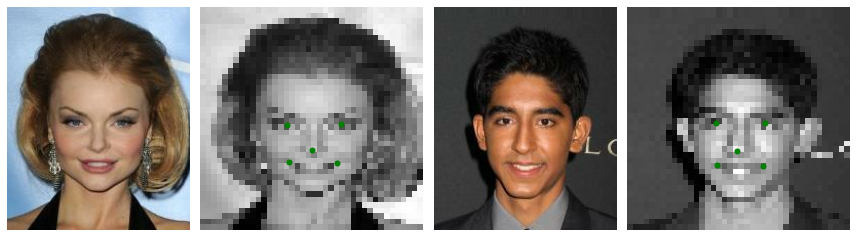

In [99]:
import IPython 
pil_img = IPython.display.Image(filename='example.png')
display(pil_img)

Aquí implementamos el dataloader y las funcionalidades para manejar los datos de entrada

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import time
from IPython.display import clear_output
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image


class FaceDataset(Dataset):

    def __init__(self, annotation_path, images_dir, primary_task, auxiliary_task=None):
        # read csv and store relevant data
        annotations = pd.read_csv(annotation_path, sep=';') 
        self.images_dir = images_dir
        self.primary_task = primary_task
        self.auxiliary_task = auxiliary_task
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.filenames = list(annotations['filename'])
        self.primary_label = list(annotations[primary_task])
        if auxiliary_task == 'Landmarks':
            self.auxiliary_label = annotations.iloc[:,1:11]
        elif auxiliary_task is not None:
            self.auxiliary_label = list(annotations[auxiliary_task])
        else:
            self.auxiliary_label = None

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # read image file and apply transformation
        img_path = os.path.join(self.images_dir, self.filenames[idx])
        img_orig = Image.open(img_path)
        img = self.transform(img_orig)

        main_label = torch.tensor([float(self.primary_label[idx])]).float()

        if self.auxiliary_task == 'Landmarks':
            secondary_label = torch.tensor(np.array(self.auxiliary_label.iloc[idx,:]).astype('float')).float()
        elif self.auxiliary_task is not None:
            secondary_label = torch.tensor([float(self.auxiliary_label[idx])]).float()
        else:
            return { 'image': img, 'main_label': main_label }

        return { 'image': img, 'main_label': main_label, 'auxiliary_label': secondary_label }


def collate_imgs(batch):
    # custom function to create the batches in the format that we want

    # append elements to the corresponding entry of this new dictionary
    batch_dict = {}
    for item in batch:
        for key in item:
            if key not in batch_dict:
                batch_dict[key] = [item[key].unsqueeze(0)]
            else:
                batch_dict[key].append(item[key].unsqueeze(0))

    # convert into tensors
    for key in batch_dict.keys():
        batch_dict[key] = torch.cat(batch_dict[key])

    return batch_dict

Y luego creamos nuestro modelo.
Intencionalmente usamos una arquitectura casi idéntica a la del Experimento 1. La principal diferencia es que incorporamos opcionalmente una predicción auxiliar que puede ser binaria o de 10 dimensiones, según la tarea.

In [ ]:
!if [ ! -f modelo3.png ]; then wget -q https://www.dropbox.com/s/49se5glxq37lgi5/modelo3.png; fi
import IPython 
pil_img = IPython.display.Image(filename='modelo3.png')
display(pil_img)

In [2]:
import torch.nn as nn
import torch.nn.functional as F


class FaceModel(nn.Module):
    def __init__(self, auxiliary_task_dim=10):
        super(FaceModel, self).__init__()
        self.auxiliary_task_dim = auxiliary_task_dim
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        if auxiliary_task_dim is not None:
            self.fc4 = nn.Linear(84, auxiliary_task_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        main_task = self.fc3(x)
        if self.auxiliary_task_dim is not None:
            auxiliary_task = self.fc4(x)
            return main_task, auxiliary_task
        else:
            return main_task, None

En la siguiente celda implementamos funcionalidades para calcular métricas y el loop de entrenamiento / test

In [3]:
def compute_landmarks_distances(real, pred):
    # compute element-wise difference (xi_pred - xi_real)
    diff = real - pred

    # compute element-wise square (xi_pred - xi_real)**2
    squared_diff = torch.mul(diff, diff)

    # reshape to 2 columns, so that each (xi, yi) are in one row
    pairs = squared_diff.reshape(-1, 2)

    # compute sqrt((xi_pred - xi_real)**2 + (yi_pred - yi_real)**2)
    distances = torch.sqrt(torch.sum(pairs,1))

    # replace nan by zero generated by sqrt(negative) due to floating point imprecisions 
    distances[torch.isnan(distances)] = 0.0

    return distances


def compute_corrects(real, pred):
    # compute final predictions. Remember that we ommited the sigmoid, so 
    # positive values will be one, as sigmoid(positive_value) is closer to 1 than to 0. 
    # Negative values will be zero, as sigmoid(negative_value) is closer to 0 than to 1. 
    final_preds = (pred > 0.0).float()

    # compute element-wise absolute difference (xi_pred - xi_real)
    diff = torch.abs(real.float() - final_preds)

    # element is correct if the difference is lower than 0.5
    corrects = (diff < 0.5).float()

    return corrects


def train_loop(model, train_dataloader, val_dataloader, optimizer, criterion, epochs, device):

    # train loop
    best_val_acc = -1.0
    best_epoch = -1
    best_weights = None
    for epoch in range(epochs):

        print('\nTRAINING EPOCH {} of {}'.format(epoch+1, epochs))

        # TRAIN
        model.train()
        for item in train_dataloader:
            # send image and labels to the device
            image = item['image'].to(device)

            # create a list of all labels. The first one corresponds to the primary task
            main_labels = item['main_label'].to(device)
            auxiliary_labels = None
            if 'auxiliary_label' in item:
                auxiliary_labels = item['auxiliary_label'].to(device)
            
            # clear gradients
            optimizer.zero_grad()

            # forward pass
            main_predictions, auxiliary_predictions = model(image)

            # compute loss
            loss = criterion(main_predictions, auxiliary_predictions, main_labels, auxiliary_labels)

            # backward pass
            loss.backward()

            optimizer.step()


        # EVALUATE IN DEV SET
        model.eval()
        item_count = 0
        running_metrics = { 'loss': 0.0, 'primary_task_acc': 0.0}
        with torch.set_grad_enabled(False):
            for item in val_dataloader:
                # send image and labels to the device
                image = item['image'].to(device)

                # create a list of all labels. The first one corresponds to the primary task
                main_labels = item['main_label'].to(device)
                auxiliary_labels = None
                if 'auxiliary_label' in item:
                    auxiliary_labels = item['auxiliary_label'].to(device)
                
                # forward pass
                main_predictions, auxiliary_predictions = model(image)

                # compute loss
                loss = criterion(main_predictions, auxiliary_predictions, main_labels, auxiliary_labels)
                
                # update statistics
                batch_sz = image.size(0)    
                item_count += batch_sz
                running_metrics['loss'] += loss.item() * float(batch_sz)
                
                # count number of correctly classified samples 
                # (later on we will divide by the total)
                corrects = compute_corrects(main_labels, main_predictions)
                running_metrics['primary_task_acc'] += torch.sum(corrects)

            # divide by total, to get the average, and print statistics
            epoch_metrics = { key: float(running_metrics[key]) / float(item_count) for key in running_metrics } 
            print('   Dev set statistics')
            print('     loss:        {0:.15f}'.format(epoch_metrics['loss']))
            print('     accuracy:    {0:.15f}'.format(epoch_metrics['primary_task_acc']))

            # store best model if needed
            if epoch_metrics['primary_task_acc'] > best_val_acc:
                best_val_acc = epoch_metrics['primary_task_acc']
                best_epoch = epoch
                best_weights = model.state_dict()
            print('     Best Accuracy:   {0:.5f}'.format(best_val_acc))

    return { 'best_acc': best_val_acc, 
             'best_epoch': best_epoch, 
             'best_weights': best_weights }

    return result


En esta clase implementaremos nuestra función de pérdida, que permite opcionalmente incorporar una pérdida correspondiente a la tarea auxiliar.

En caso de que la tarea auxiliar sea binaria, utilizaremos Cross-Entropy (binaria), pero si es la tarea de 'Landmarks', usaremos MSE, pues queremos que el modelo maneje la predicción de las coordenadas (x,y) como un problema de regresión.

La tarea principal, por simplicidad, asumiremos que siempre es binaria (y por lo tanto usaremos Cross-Entropy.

Recordemos lo que vimos en clases sobre cómo combinar ambas pérdidas:

$$ \mathit{Loss} = \mathit{Loss}_{principal} + \lambda \mathit{Loss}_{auxiliar} $$

In [4]:
class CombinedLoss(nn.Module):

    def __init__(self, auxiliary_task, auxiliary_weight):
        super(CombinedLoss, self).__init__()

        # store relevant information
        self.auxiliary_task = auxiliary_task
        self.aux_weight = auxiliary_weight # this is the weight "lambda" to combine both loss functions
        
    def forward(self, main_predictions, auxiliary_predictions, main_labels, auxiliary_labels):

        if auxiliary_labels is None:
            # if we are not using auxiliary task, just return a cross-entropy
            return F.binary_cross_entropy_with_logits(main_predictions, main_labels)
        else:
            # if we are using auxiliary task, return the main cross-entropy and the auxiliary loss, combined
            main_loss = F.binary_cross_entropy_with_logits(main_predictions, main_labels)
            if self.auxiliary_task == 'Landmarks':
                aux_loss = F.mse_loss(auxiliary_predictions, auxiliary_labels)
            else:
                aux_loss = F.binary_cross_entropy_with_logits(auxiliary_predictions, auxiliary_labels)

            # return main_loss + lambda * auxiliary_loss
            return main_loss + self.aux_weight * aux_loss

A continuación está el código para lanzar el entrenamiento. En este primer ejemplo, usaremos como tarea principal el atributo 'Smiling' sin tarea auxiliar.

In [5]:
images_path = 'celebA'
batch_size = 32
epochs = 10
learning_rate = 0.001
primary_task = 'Smiling'
auxiliary_task = None
auxiliary_weight = None
weight_decay = 0.0

train_dataset = FaceDataset('annotations_train.csv', images_path, primary_task, auxiliary_task=auxiliary_task)
val_dataset = FaceDataset('annotations_val.csv', images_path, primary_task, auxiliary_task=auxiliary_task)
test_dataset = FaceDataset('annotations_test.csv', images_path, primary_task, auxiliary_task=auxiliary_task)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_imgs)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_imgs)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_imgs)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if auxiliary_task is None:
    model = FaceModel(None).to(device)
elif auxiliary_task == 'Landmarks':
    model = FaceModel(10).to(device)
else:
    model = FaceModel(1).to(device)

criterion = CombinedLoss(auxiliary_task, auxiliary_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

training_result = train_loop(model, train_dataloader, val_dataloader, optimizer, criterion, epochs, device)


TRAINING EPOCH 1 of 10
   Dev set statistics
     loss:        0.344133260059357
     accuracy:    0.853400000000000
     Best Accuracy:   0.85340

TRAINING EPOCH 2 of 10
   Dev set statistics
     loss:        0.312277481245995
     accuracy:    0.861100000000000
     Best Accuracy:   0.86110

TRAINING EPOCH 3 of 10
   Dev set statistics
     loss:        0.276892793464661
     accuracy:    0.881100000000000
     Best Accuracy:   0.88110

TRAINING EPOCH 4 of 10
   Dev set statistics
     loss:        0.309384719276428
     accuracy:    0.868100000000000
     Best Accuracy:   0.88110

TRAINING EPOCH 5 of 10
   Dev set statistics
     loss:        0.324674748826027
     accuracy:    0.860500000000000
     Best Accuracy:   0.88110

TRAINING EPOCH 6 of 10
   Dev set statistics
     loss:        0.267685073065758
     accuracy:    0.886900000000000
     Best Accuracy:   0.88690

TRAINING EPOCH 7 of 10
   Dev set statistics
     loss:        0.280299085140228
     accuracy:    0.8811000000

Ahora probaremos el mismo modelo, pero usando una tarea auxiliar binaria ("Young")

In [6]:
images_path = 'celebA'
batch_size = 30
epochs = 10
learning_rate = 0.001
primary_task = 'Smiling'
auxiliary_task = 'Young'
auxiliary_weight = 0.2
weight_decay = 0.0

train_dataset = FaceDataset('annotations_train.csv', images_path, primary_task, auxiliary_task=auxiliary_task)
val_dataset = FaceDataset('annotations_val.csv', images_path, primary_task, auxiliary_task=auxiliary_task)
test_dataset = FaceDataset('annotations_test.csv', images_path, primary_task, auxiliary_task=auxiliary_task)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_imgs)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_imgs)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_imgs)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if auxiliary_task is None:
    model = FaceModel(None).to(device)
elif auxiliary_task == 'Landmarks':
    model = FaceModel(10).to(device)
else:
    model = FaceModel(1).to(device)

criterion = CombinedLoss(auxiliary_task, auxiliary_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

training_result = train_loop(model, train_dataloader, val_dataloader, optimizer, criterion, epochs, device)


TRAINING EPOCH 1 of 10
   Dev set statistics
     loss:        0.515640123248100
     accuracy:    0.819300000000000
     Best Accuracy:   0.81930

TRAINING EPOCH 2 of 10
   Dev set statistics
     loss:        0.410055677160621
     accuracy:    0.867300000000000
     Best Accuracy:   0.86730

TRAINING EPOCH 3 of 10
   Dev set statistics
     loss:        0.386355359315872
     accuracy:    0.877100000000000
     Best Accuracy:   0.87710

TRAINING EPOCH 4 of 10
   Dev set statistics
     loss:        0.381324750289321
     accuracy:    0.879400000000000
     Best Accuracy:   0.87940

TRAINING EPOCH 5 of 10
   Dev set statistics
     loss:        0.380328614741564
     accuracy:    0.883700000000000
     Best Accuracy:   0.88370

TRAINING EPOCH 6 of 10
   Dev set statistics
     loss:        0.403085761159658
     accuracy:    0.871700000000000
     Best Accuracy:   0.88370

TRAINING EPOCH 7 of 10
   Dev set statistics
     loss:        0.388505390554667
     accuracy:    0.8826000000

Finalmente probaremos una tarea principal de clasificación binaria ("Young") con una tarea auxiliar de regresión ("Landmarks"), para ver que pueden ser combinadas aunque sean de tipo diferente.

In [7]:
images_path = 'celebA'
batch_size = 64
epochs = 20
learning_rate = 0.001
primary_task = 'Young'
auxiliary_task = 'Landmarks'
auxiliary_weight = 0.1
weight_decay = 0.0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = FaceDataset('annotations_train.csv', images_path, primary_task, auxiliary_task=auxiliary_task)
val_dataset = FaceDataset('annotations_val.csv', images_path, primary_task, auxiliary_task=auxiliary_task)
test_dataset = FaceDataset('annotations_test.csv', images_path, primary_task, auxiliary_task=auxiliary_task)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_imgs)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_imgs)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_imgs)

if auxiliary_task is None:
    model = FaceModel(None).to(device)
elif auxiliary_task == 'Landmarks':
    model = FaceModel(10).to(device)
else:
    model = FaceModel(1).to(device)

criterion = CombinedLoss(auxiliary_task, auxiliary_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

training_result = train_loop(model, train_dataloader, val_dataloader, optimizer, criterion, epochs, device)


TRAINING EPOCH 1 of 20
   Dev set statistics
     loss:        0.559134128665924
     accuracy:    0.741600000000000
     Best Accuracy:   0.74160

TRAINING EPOCH 2 of 20
   Dev set statistics
     loss:        0.552548274803162
     accuracy:    0.755300000000000
     Best Accuracy:   0.75530

TRAINING EPOCH 3 of 20
   Dev set statistics
     loss:        0.478913812160492
     accuracy:    0.792800000000000
     Best Accuracy:   0.79280

TRAINING EPOCH 4 of 20
   Dev set statistics
     loss:        0.460046500587463
     accuracy:    0.795500000000000
     Best Accuracy:   0.79550

TRAINING EPOCH 5 of 20
   Dev set statistics
     loss:        0.459057250976563
     accuracy:    0.798300000000000
     Best Accuracy:   0.79830

TRAINING EPOCH 6 of 20
   Dev set statistics
     loss:        0.463209647083282
     accuracy:    0.791000000000000
     Best Accuracy:   0.79830

TRAINING EPOCH 7 of 20
   Dev set statistics
     loss:        0.456520463132858
     accuracy:    0.8034000000

## Actividades

*    **1. Supongamos que usted quiere combinar una tarea principal con una tarea auxiliar, pero por la naturaleza de las tareas y funciones de pérdida, la loss asociada a la tarea auxiliar es, por lo general, 1000 veces mayor que la de la tarea principal (es decir, cuando la loss de la tarea principal vale 100, la de la auxiliar vale 100000). ¿Qué tendría que hacer para que el modelo considere ambas pérdidas de manera equilibrada (50%-50%)?**


In [ ]:
#@title Respuesta 1

Respuesta = 'Se aplica un multiplicador o una funcion al resultado del loss al momento de sumar los errores del modelo (Ej: 100 + 100000 * 0.001)' #@param {type:"string"}

*    **2. Supongamos ahora que tenemos una tarea principal y 4 tareas auxiliares, todas con ordenes de magnitud similar. ¿Qué tendría que hacer para que el modelo considere la pérdida de la tarea principal en un 50% y la pérdida de todas las demás homogeneamente completando el otro 50%?**

In [ ]:
#@title Respuesta 2

Respuesta = 'podría ser algo como  P * 0.5 + (aux1 + aux2 + aux3 + aux4)) * 0.5' #@param {type:"string"}